# 11.2.2 Interpretability methods to explain black box models

## Heat Maps

#### Load Packages

In [1]:
import numpy as np
import pandas as pd #to work with csv files

#matplotlib imports are used to plot confusion matrices for the classifiers
import matplotlib as mpl 
import matplotlib.cm as cm 
import matplotlib.pyplot as plt 

#import time function from time module to track the training duration
from time import time
from collections import OrderedDict

import seaborn as sns
from collections import OrderedDict

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator,DirectoryIterator
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras import backend as K
import os
import tensorflow as tf
import shutil
import keras

#### Loading the Xception network with pretrained weights

In [12]:
model = keras.applications.xception.Xception(weights="imagenet")

img_path = keras.utils.get_file(
    fname="dog.jpg",
    origin="https://protectmypaws.com/wp-content/uploads/2023/07/happy-dogs.jpg")

#### Preprocessing an input image for Xception

In [3]:
def get_img_array(img_path, target_size):
    img = keras.utils.load_img(img_path, target_size=target_size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    array = keras.applications.xception.preprocess_input(array)
    return array

img_array = get_img_array(img_path, target_size=(299, 299))

preds = model.predict(img_array)
print(keras.applications.xception.decode_predictions(preds, top=3)[0])

np.argmax(preds[0])

1/1 [==============================] - 3s 3s/step
[('n02113023', 'Pembroke', 0.08472376), ('n02113186', 'Cardigan', 0.047116272), ('n02110806', 'basenji', 0.04071725)]


263

#### Setting up a model that returns the last convolutional output

In [5]:
last_conv_layer_name = "block14_sepconv2_act"
classifier_layer_names = [
    "avg_pool",
    "predictions",
]
last_conv_layer = model.get_layer(last_conv_layer_name)
last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

#### Reapplying the classifier on top of the last convolutional output

In [6]:
classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in classifier_layer_names:
    x = model.get_layer(layer_name)(x)
classifier_model = keras.Model(classifier_input, x)

#### Retrieving the gradients of the top predicted class

In [7]:
import tensorflow as tf

with tf.GradientTape() as tape:
    last_conv_layer_output = last_conv_layer_model(img_array)
    tape.watch(last_conv_layer_output)
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]

grads = tape.gradient(top_class_channel, last_conv_layer_output)

#### Gradient pooling and channel-importance weighting

In [8]:
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy()
last_conv_layer_output = last_conv_layer_output.numpy()[0]
for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]
heatmap = np.mean(last_conv_layer_output, axis=-1)

#### Heatmap post-processing

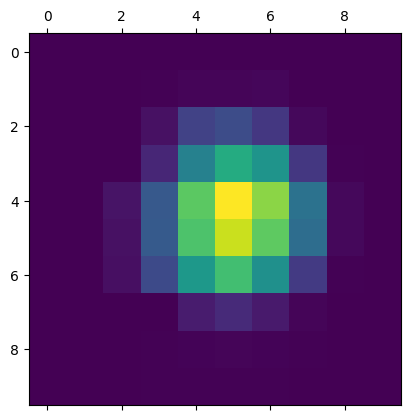

In [9]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

#### Superimposing the heatmap on the original picture

C:\Users\boukouva\AppData\Local\Temp\ipykernel_11708\2121987801.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


<Figure size 640x480 with 0 Axes>

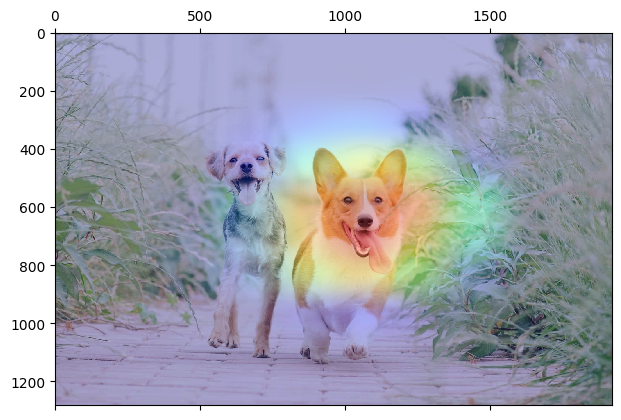

In [10]:
import matplotlib.cm as cm

img = keras.utils.load_img(img_path)
img = keras.utils.img_to_array(img)

heatmap = np.uint8(255 * heatmap)

jet = cm.get_cmap("jet")
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

jet_heatmap = keras.utils.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.utils.img_to_array(jet_heatmap)

superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = keras.utils.array_to_img(superimposed_img)

save_path = "happy_dogs.jpg"
superimposed_img.save(save_path)

# Save the superimposed image to PDF
plt.savefig("CAM_output.pdf", format="pdf", bbox_inches="tight")

# Display the image (optional)
plt.show()

plt.matshow(superimposed_img)